In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지않습니다. CPU환경에서 실행됩니다.")

GPU가 감지되지않습니다. CPU환경에서 실행됩니다.


In [33]:
import os
file_path = os.getcwd()
train_path = os.path.join(file_path, "데이터셋", "train.csv")
test_path = os.path.join(file_path, "데이터셋", "test.csv")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)


In [34]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["신용점수분위"] = pd.qcut(df["신용 점수"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["대출잔액 분위수"] = pd.qcut(df["현재 대출 잔액"], 5, labels = [1,2,3,4,5], duplicates= "drop").astype(int)

    df["위험분자1"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["연간소득분위"] < 3)).astype(int)
    df["위험분자2"] = (((df["신용 문제 발생 횟수"] > 0) & (df["개인 파산 횟수"] > 0)) | (df["체납 세금 압류 횟수"] > 0)).astype(int)
    df["위험분자3"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["대출잔액 분위수"] > 3)).astype(int)
    df["위험분자4"] = ((df["신용점수분위"] < 3) & (df["개설된_신용계좌_분위수"] > 3)).astype(int)

    df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용거래분위"] > 3)).astype(int)
    


    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] +1 )  / (df["최대 신용한도"] + 1)* 100
    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
   
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
        
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    df["목적별_개설된_신용계좌수_평균"] = df["대출 목적"].map(bankcount_purpose)
    #df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    #df["계좌수별_소득"] = df["계좌수별_소득"].astype(int)

    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,개설된_신용계좌_분위수,대출잔액 분위수,위험분자1,위험분자2,위험분자3,위험분자4,VIP,신용한도vs대출잔액,신용거래연수_개설신용계좌,목적별_개설된_신용계좌수_평균
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,2,2,0,0,0,0,0,97.579996,18.571922,12.0
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,1,5,0,0,0,0,0,277.859629,18.039216,12.0
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,3,1,0,1,0,0,0,46.317446,18.984709,12.0
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,4,1,1,1,0,0,0,61.082817,19.806630,12.0
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,2,5,0,0,0,0,0,129.921941,19.110526,12.0


In [35]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

In [36]:
from scipy.stats import boxcox

cols = ["최대 신용한도", "현재 대출 잔액", "현재 미상환 신용액", "연간 소득", "월 상환 부채액","신용한도vs대출잔액", "신용 점수"]
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())
    
    train[c], l = boxcox(train[c])
    test[c]= boxcox(test[c], lmbda = l)
print(train[cols].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   최대 신용한도     10000 non-null  float64
 1   현재 대출 잔액    10000 non-null  float64
 2   현재 미상환 신용액  10000 non-null  float64
 3   연간 소득       10000 non-null  float64
 4   월 상환 부채액    10000 non-null  float64
 5   신용한도vs대출잔액  10000 non-null  float64
 6   신용 점수       10000 non-null  float64
dtypes: float64(7)
memory usage: 547.0 KB
None


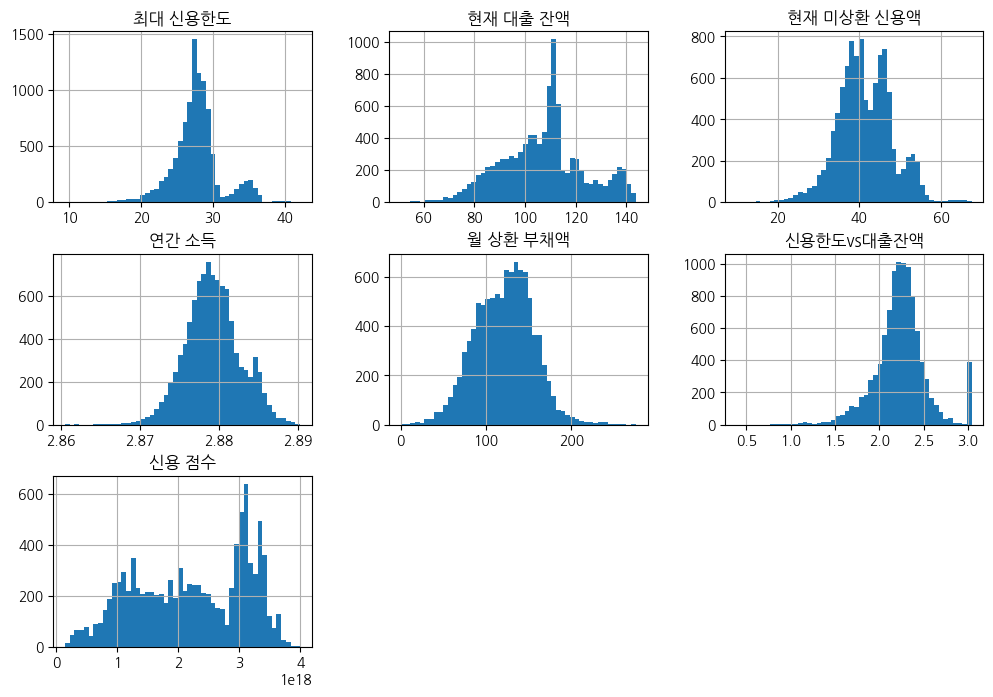

In [37]:
import matplotlib.font_manager as fm

plt.rc("font", family = "NanumGothic")

train[cols].hist(figsize = (12,8), bins = 50);

In [38]:
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    test[c] = test[c].where((test[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].fillna(test[c].median())

In [39]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(train)
test_scaled = minmax.transform(test)

In [40]:
smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold 1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5019 - loss: 0.6992 - val_accuracy: 0.5091 - val_loss: 0.6899
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5133 - loss: 0.6947 - val_accuracy: 0.5857 - val_loss: 0.6840
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5281 - loss: 0.6891 - val_accuracy: 0.6316 - val_loss: 0.6793
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5589 - loss: 0.6863 - val_accuracy: 0.6411 - val_loss: 0.6752
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5828 - loss: 0.6798 - val_accuracy: 0.6491 - val_loss: 0.6707
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5937 - loss: 0.6782 - val_accuracy: 0.6578 - val_loss: 0.6662
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6023 - loss: 0.6717 - val_accuracy: 0.6608 - val_loss: 0.6611
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5930 - loss: 0.6735 - val_accuracy: 0.6639

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4882 - loss: 0.6978 - val_accuracy: 0.4899 - val_loss: 0.6941
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5031 - loss: 0.6948 - val_accuracy: 0.5545 - val_loss: 0.6894
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5311 - loss: 0.6898 - val_accuracy: 0.5935 - val_loss: 0.6851
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5444 - loss: 0.6881 - val_accuracy: 0.6144 - val_loss: 0.6814
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5689 - loss: 0.6825 - val_accuracy: 0.6190 - val_loss: 0.6779
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5888 - loss: 0.6803 - val_accuracy: 0.6262 - val_loss: 0.6746
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5989 - loss: 0.6770 - val_accuracy: 0.6334 - val_loss: 0.6713
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6152 - loss: 0.6729 - val_accuracy: 0.6353

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5112 - loss: 0.6956 - val_accuracy: 0.5560 - val_loss: 0.6893
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5385 - loss: 0.6899 - val_accuracy: 0.5791 - val_loss: 0.6847
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5511 - loss: 0.6866 - val_accuracy: 0.6049 - val_loss: 0.6808
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5730 - loss: 0.6811 - val_accuracy: 0.6194 - val_loss: 0.6771
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5857 - loss: 0.6774 - val_accuracy: 0.6216 - val_loss: 0.6732
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5933 - loss: 0.6726 - val_accuracy: 0.6285 - val_loss: 0.6694
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6053 - loss: 0.6700 - val_accuracy: 0.6304 - val_loss: 0.6657
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6080 - loss: 0.6680 - val_accuracy: 0.6319

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5312 - loss: 0.6903 - val_accuracy: 0.5905 - val_loss: 0.6858
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5440 - loss: 0.6892 - val_accuracy: 0.6140 - val_loss: 0.6827
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5608 - loss: 0.6854 - val_accuracy: 0.6311 - val_loss: 0.6795
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5789 - loss: 0.6821 - val_accuracy: 0.6323 - val_loss: 0.6763
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5998 - loss: 0.6782 - val_accuracy: 0.6406 - val_loss: 0.6725
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5996 - loss: 0.6765 - val_accuracy: 0.6471 - val_loss: 0.6688
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6162 - loss: 0.6710 - val_accuracy: 0.6493 - val_loss: 0.6646
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6189 - loss: 0.6682 - val_accuracy: 0.6512

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4944 - loss: 0.7026 - val_accuracy: 0.5025 - val_loss: 0.6949
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5182 - loss: 0.6929 - val_accuracy: 0.5389 - val_loss: 0.6903
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5233 - loss: 0.6922 - val_accuracy: 0.5655 - val_loss: 0.6870
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5258 - loss: 0.6917 - val_accuracy: 0.5905 - val_loss: 0.6841
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5508 - loss: 0.6847 - val_accuracy: 0.6065 - val_loss: 0.6812
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5627 - loss: 0.6835 - val_accuracy: 0.6148 - val_loss: 0.6780
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5801 - loss: 0.6803 - val_accuracy: 0.6243 - val_loss: 0.6747
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5944 - loss: 0.6781 - val_accuracy: 0.6304

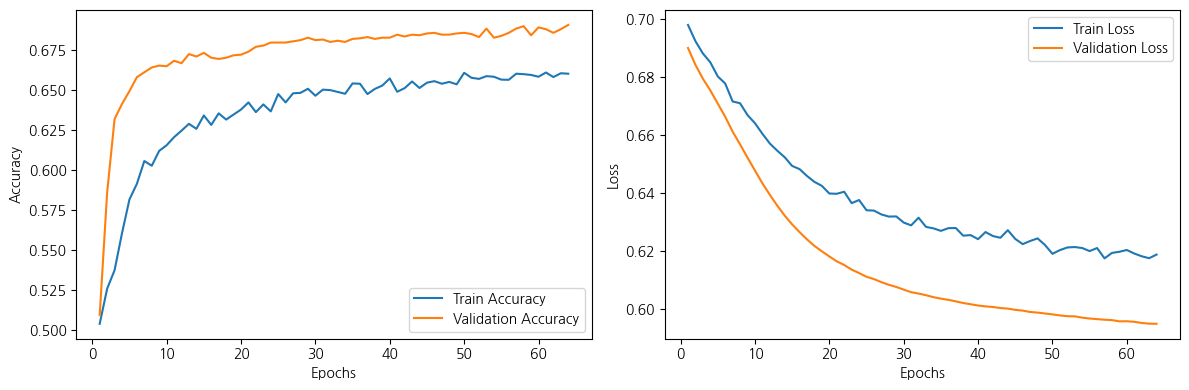

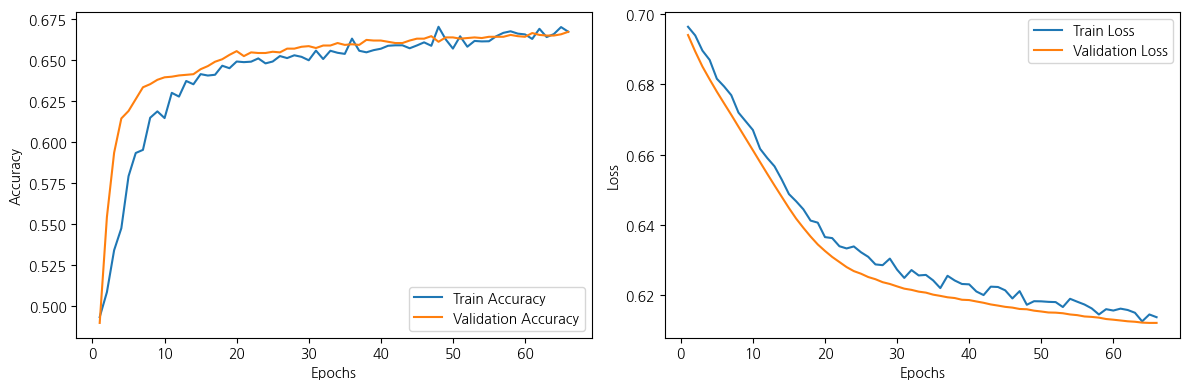

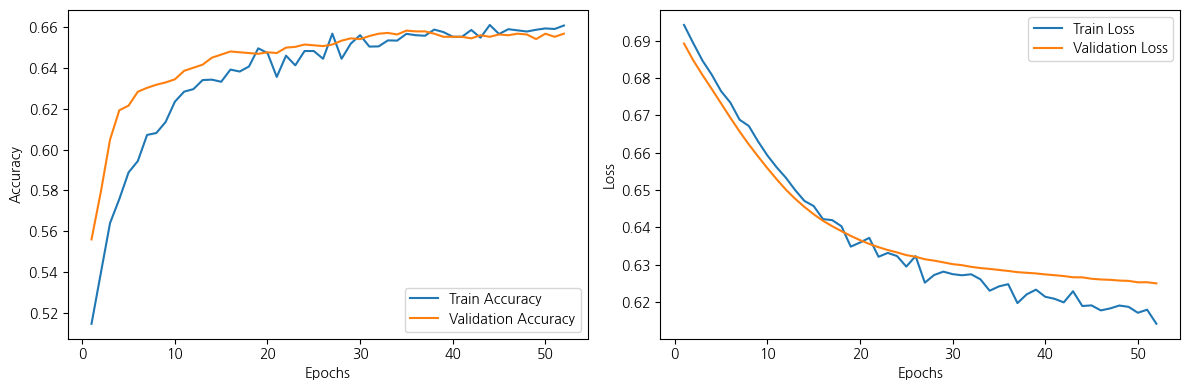

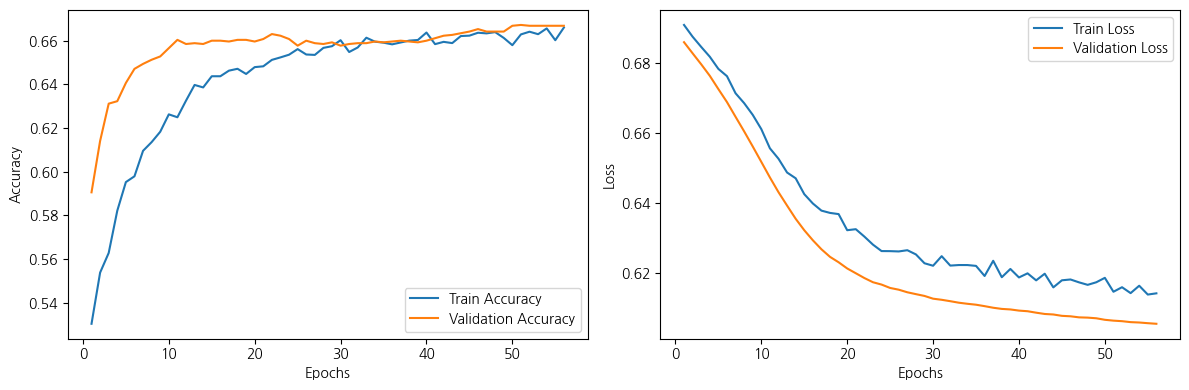

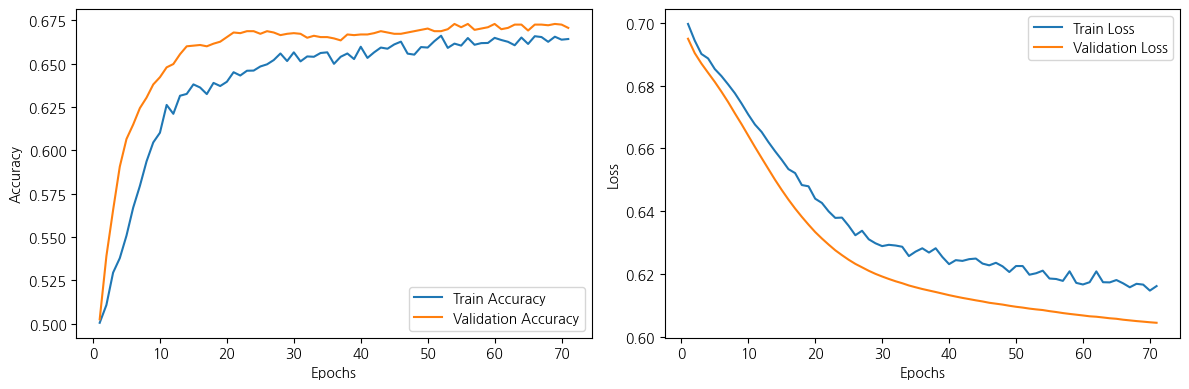

In [41]:
all_history = []
kf = KFold(n_splits = 5, shuffle= True, random_state= 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold {fold} 시작!")
    
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation= "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation= "relu"),
        tf.keras.layers.Dense(1, activation= "sigmoid")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )

    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        callbacks = earlystop,
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold{fold} ROC-AUC score {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차 검증 ROC-AUC 평균점수 {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [42]:
pred = model.predict(test_scaled).ravel()


submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100 })
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission(2025-03-13).csv", index = False)
submission.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,UID,채무 불이행 확률
0,TEST_0000,73.649887
1,TEST_0001,38.414642
2,TEST_0002,33.402832
3,TEST_0003,21.782755
4,TEST_0004,29.504208
